# Libraries

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim  as optim

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm, trange

import time

## Data

In [2]:
full_dataset=np.load(r'CatsVDogs\training_data.npy',allow_pickle=True)
train_set, val_set = torch.utils.data.random_split(full_dataset, [int(len(full_dataset)*0.75)+1, int(len(full_dataset)*0.25)])

X = torch.Tensor([i[0] for i in train_set])
Y = torch.Tensor([i[1] for i in train_set])

X_a = torch.Tensor([i[0] for i in val_set])
Y_a = torch.Tensor([i[1] for i in val_set])

In [3]:
print(f'Full dataset shape :\t[{np.size(full_dataset)}, {np.size(full_dataset[0])}, {np.size(full_dataset[0][0])}, {np.size(full_dataset[0][0][0])}, {np.size(full_dataset[0][0][0][0])}]\t\tdtype:\t{full_dataset.dtype}\n\n')
print(f'\tTraining dataset shape :\t[{np.size(train_set)}, {np.size(train_set[0])}, {np.size(train_set[0][0])}, {np.size(train_set[0][0][0])}, {np.size(train_set[0][0][0][0])}]\n')
print(f'\t\t Input training  shape:\t\t{list(X.shape)}\t\tdtype:\t{X.dtype}\n')
print(f'\t\t Output training  shape:\t{list(Y.shape)}\t\tdtype:\t{Y.dtype}\n\n')
print(f'\tValidation dataset shape :\t[{np.size(val_set)}, {np.size(val_set[0])}, {np.size(val_set[0][0])}, {np.size(val_set[0][0][0])}, {np.size(val_set[0][0][0][0])}]\n')
print(f'\t\t Input validation  shape:\t{list(X_a.shape)}\t\tdtype:\t{X_a.dtype}\n')
print(f'\t\t Output validation  shape:\t{list(Y_a.shape)}\t\tdtype:\t{Y_a.dtype}')

Full dataset shape :	[49892, 2, 2500, 50, 1]		dtype:	object


	Training dataset shape :	[37420, 2, 2500, 50, 1]

		 Input training  shape:		[18710, 50, 50]		dtype:	torch.float32

		 Output training  shape:	[18710, 2]		dtype:	torch.float32


	Validation dataset shape :	[12472, 2, 2500, 50, 1]

		 Input validation  shape:	[6236, 50, 50]		dtype:	torch.float32

		 Output validation  shape:	[6236, 2]		dtype:	torch.float32


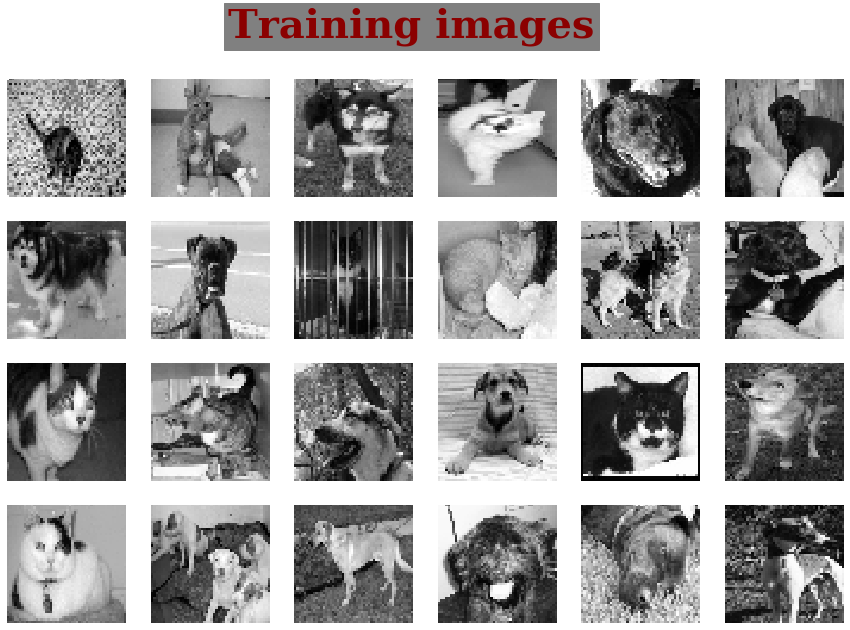

In [4]:
plt.figure(figsize=(15,10))
plt.suptitle('Training images', c='darkred', fontsize=40, weight='bold', family = 'serif', backgroundcolor = 'gray')
for i in range(24):
    plt.subplot(4,6,i+1)
    plt.axis('off')
    plt.imshow(X[i],cmap='gray')

## Model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        self.fc1=nn.Linear(128*2*2, 170, bias=True)
        self.fc2=nn.Linear(170, 56, bias=True)
        self.fc3=nn.Linear(56, 2, bias=True)
    
    def forward(self,x):
        
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        x = torch.flatten(x, start_dim=1)
        
        x= F.relu(self.fc1(x)) 
        x= F.relu(self.fc2(x))
        x= self.fc3(x)
        
        return F.softmax(x, dim=1)

## CUDA

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    net_class = Net().to(device)
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    net_class = Net()
    print("Running on the CPU")
    
print(f'\nClass architecture\n\n{net_class}')

Running on the GPU

Class architecture

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=170, bias=True)
  (fc2): Linear(in_features=170, out_features=56, bias=True)
  (fc3): Linear(in_features=56, out_features=2, bias=True)
)


In [7]:
x = (torch.randn(50,50).view(-1,1,50,50)).to(device)
forward = net_class(x)
print(f'Result shape: {list(forward.shape)}\tdtype: {forward.dtype}')

Result shape: [1, 2]	dtype: torch.float32


## Training loop

In [8]:
BATCH_SIZE = 100
EPOCHS = 30

optimizer = optim.Adam(net_class.parameters(),lr= 0.0002)
loss_function = nn.MSELoss()

loss_grap=[]
mean_grap=[]
prin = True

print(f'\nTraining Loop\n')

start_time = time.time()

for epoch in range(EPOCHS):
    loss_mean=0
    for i in trange(0, len(train_set), BATCH_SIZE,  desc='Loss calculation'):
        
        batch_X=X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y=Y[i:i+BATCH_SIZE]
        
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        if prin:
            print(f'Input shape: {list(batch_X.shape)}')
        
        net_class.zero_grad()
        outputs = net_class(batch_X)
        
        if prin:
            print(f'\nOutput shape: {list(outputs.shape)}\t Y shape: {list(batch_y.shape)}\n')
            prin = False
                
        loss = loss_function(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        loss_grap.append(loss)
        loss_mean+=loss
    print(f'Epoch {epoch+1} error mean {(((loss_mean/i).item())*100):.5f}')
    mean_grap.append(((loss_mean/i).item())*100)

elapsed_time = time.time() - start_time

print(f'\nTraining time:\t[ {int(elapsed_time // 60)} : {int(elapsed_time % 60)} : {int(((elapsed_time % 60) % 1)*100)} ]')

Loss calculation:   1%|          | 2/188 [00:00<00:12, 14.97it/s]


Training Loop

Input shape: [100, 1, 50, 50]

Output shape: [100, 2]	 Y shape: [100, 2]



Loss calculation:   1%|          | 2/188 [00:00<00:10, 17.59it/s]

Epoch 1 error mean 0.23963


Loss calculation:   1%|          | 2/188 [00:00<00:10, 17.90it/s]

Epoch 2 error mean 0.21047


Loss calculation:   1%|          | 2/188 [00:00<00:10, 17.76it/s]

Epoch 3 error mean 0.18981


Loss calculation:   1%|          | 2/188 [00:00<00:10, 17.75it/s]

Epoch 4 error mean 0.17270


Loss calculation:   1%|          | 2/188 [00:00<00:11, 15.92it/s]

Epoch 5 error mean 0.15652


Loss calculation:   1%|          | 2/188 [00:00<00:10, 18.07it/s]

Epoch 6 error mean 0.14012


Loss calculation:   1%|          | 2/188 [00:00<00:10, 17.82it/s]

Epoch 7 error mean 0.12843


Loss calculation:   1%|          | 2/188 [00:00<00:10, 17.14it/s]

Epoch 8 error mean 0.12229


Loss calculation:   1%|          | 2/188 [00:00<00:10, 17.14it/s]

Epoch 9 error mean 0.11243


Loss calculation:   1%|          | 2/188 [00:00<00:11, 16.64it/s]

Epoch 10 error mean 0.11000


Loss calculation:   1%|          | 2/188 [00:00<00:10, 17.14it/s]

Epoch 11 error mean 0.10324


Loss calculation:   1%|          | 2/188 [00:00<00:10, 17.29it/s]

Epoch 12 error mean 0.09165


Loss calculation:   1%|          | 2/188 [00:00<00:10, 17.90it/s]

Epoch 13 error mean 0.07870


Loss calculation:   1%|          | 2/188 [00:00<00:11, 16.57it/s]

Epoch 14 error mean 0.07519


Loss calculation:   1%|          | 2/188 [00:00<00:10, 17.94it/s]

Epoch 15 error mean 0.06553


Loss calculation:   1%|          | 2/188 [00:00<00:10, 17.59it/s]

Epoch 16 error mean 0.05958


Loss calculation:   1%|          | 2/188 [00:00<00:11, 16.71it/s]

Epoch 17 error mean 0.05716


Loss calculation:   1%|          | 2/188 [00:00<00:10, 17.75it/s]

Epoch 18 error mean 0.04952


Loss calculation:   1%|          | 2/188 [00:00<00:10, 17.91it/s]

Epoch 19 error mean 0.04234


Loss calculation:   1%|          | 2/188 [00:00<00:11, 16.64it/s]

Epoch 20 error mean 0.03773


Loss calculation:   1%|          | 2/188 [00:00<00:11, 15.54it/s]

Epoch 21 error mean 0.03110


Loss calculation:   1%|          | 2/188 [00:00<00:10, 17.66it/s]

Epoch 22 error mean 0.02896


Loss calculation:   1%|          | 2/188 [00:00<00:10, 18.07it/s]

Epoch 23 error mean 0.02510


Loss calculation:   1%|          | 2/188 [00:00<00:10, 17.51it/s]

Epoch 24 error mean 0.02336


Loss calculation:   1%|          | 2/188 [00:00<00:10, 17.90it/s]

Epoch 25 error mean 0.02117


Loss calculation:   1%|          | 2/188 [00:00<00:10, 17.75it/s]

Epoch 26 error mean 0.02136


Loss calculation:   1%|          | 2/188 [00:00<00:11, 16.71it/s]

Epoch 27 error mean 0.02152


Loss calculation:   1%|          | 2/188 [00:00<00:10, 18.07it/s]

Epoch 28 error mean 0.01671


Loss calculation:   1%|          | 2/188 [00:00<00:10, 17.75it/s]

Epoch 29 error mean 0.01595


Loss calculation: 100%|██████████| 188/188 [00:14<00:00, 13.00it/s]

Epoch 30 error mean 0.01601

Training time:	[ 7 : 13 : 72 ]


## Error

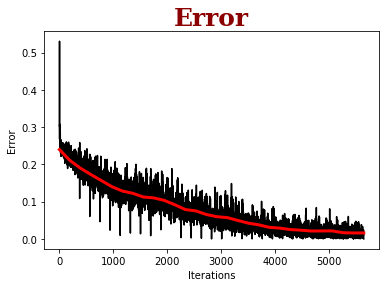

In [13]:
plt.plot(range(len(loss_grap)),loss_grap,c='black')

xpt=np.linspace(0,len(loss_grap),len(mean_grap))
xpt=[int(i) for i in xpt]

plt.plot(xpt,mean_grap,c='red',lw=3)

plt.title('Error', c='darkred', fontsize=25, weight='bold', family = 'serif')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.show()

## Accuracy

In [14]:
correct = 0
total = 0
with torch.no_grad():
    
    for i in trange(len(X_a), desc='Accuracy calculation'):
        
        X_a,Y_a = X_a.to(device), Y_a.to(device)
        
        real_class = torch.argmax(Y_a[i])
        
        net_out = net_class(X_a[i].view(-1,1,50,50))[0]
        
        predicted_class = torch.argmax(net_out)
        
        if predicted_class == real_class:
            correct += 1
        total += 1

print("Accuracy: ",round(correct/total,3))

Accuracy calculation: 100%|██████████| 6236/6236 [00:15<00:00, 390.40it/s]

Accuracy:  0.724


## New Data

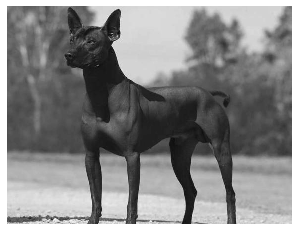

In [15]:
import cv2 

path1 = r'CatsVDogs\imgs\gat.jpg'
path2 = r'CatsVDogs\imgs\salchi.jpg'
path3 = r'CatsVDogs\imgs\malvada.jpeg'
path4 = r'CatsVDogs\imgs\charli.jpeg'
path5 = r'CatsVDogs\imgs\bartolo.jpeg'
path6 = r'CatsVDogs\imgs\boz.jpg'
  
img = cv2.imread(path6, cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.show()
img = cv2.resize(img, (50, 50))

In [16]:
innn = torch.Tensor([i for i in img])
innn = innn.to(device)
net_res = net_class(innn.view(-1,1,50,50))
print(f'Hay una certeza del {((net_res[0][0])*100):.2f} % que sea gato y un {((net_res[0][1])*100):.2f} % que sea perro')

Hay una certeza del 22.16 % que sea gato y un 77.84 % que sea perro


## Saving model

In [17]:
sv = False
if sv:
    torch.save(net_class, r'CatsVDogs\NNCatsVDogs.pt')
    torch.save(load_model.state_dict(), r'CatsVDogs\NNCVD.pt')
    print('Model saved')

## Loading model

In [18]:
ld = False
if ld:
    load_model = torch.load(r'CatsVDogs\NNCatsVDogs.pt')
    print('Model loaded\n')
    load_model = load_model.to(device)
    load_res = load_model(innn.view(-1,1,50,50))
    print(f'Hay una certeza del {((load_res[0][0])*100):.2f} % que sea gato y un {((load_res[0][1])*100):.2f} % que sea perro')